In [18]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u 
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib.patches import Ellipse
from astropy.coordinates import Distance
from astropy.wcs import WCS
from astropy.visualization import ZScaleInterval

In [19]:
fits_file = "GLM_02850_0000_mosaic_I1.fits"
hdul = fits.open(fits_file)
wcs = WCS(hdul[0].header)
data = hdul[0].data

Filename: GLM_02850_0000_mosaic_I1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      88   (6640, 4840)   float32   


WCS CTYPE: ['GLON-CAR', 'GLAT-CAR']


Gaia count after cleaning: 230578


NameError: name 'l' is not defined

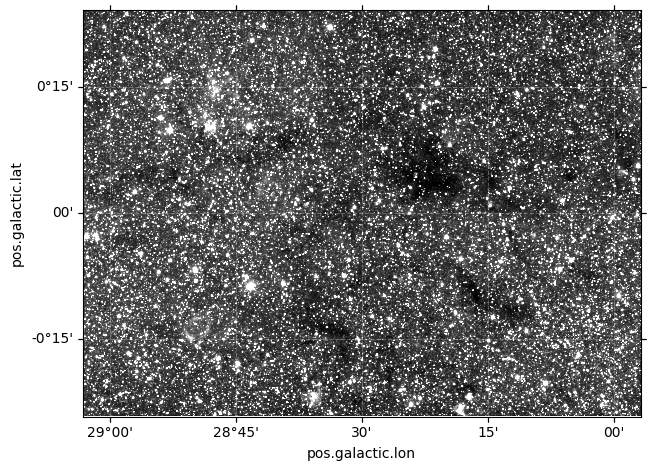

In [27]:
# ========== Load Spitzer image + WCS ==========
fits_file = "GLM_02850_0000_mosaic_I1.fits"
with fits.open(fits_file) as hdul:
    wcs  = WCS(hdul[0].header)
    data = hdul[0].data

print("WCS CTYPE:", wcs.wcs.ctype)   # e.g., ('RA---TAN','DEC--TAN') or ('GLON-TAN','GLAT-TAN')

# ========== Load Gaia catalog (Astropy Table) ==========
gaia_tab = Table.read("Cone_GaiaDR3.fits", hdu=1)

# Robustly convert Astropy Columns -> plain numpy float arrays, handling masks/NaNs
def col_to_float_array(col):
    # If MaskedColumn, drop masked entries
    if hasattr(col, "mask") and col.mask is not None:
        valid_mask = ~col.mask
        arr = np.array(col[valid_mask], dtype=float)
    else:
        arr = np.array(col, dtype=float)
    # Drop NaN/Inf
    arr = arr[np.isfinite(arr)]
    return arr

ra  = col_to_float_array(gaia_tab["ra"])
dec = col_to_float_array(gaia_tab["dec"])

# Make sure ra, dec stay aligned if masking removed different indices:
# Re-build in one pass to preserve alignment.
if hasattr(gaia_tab["ra"], "mask") or hasattr(gaia_tab["dec"], "mask"):
    # Build a single validity mask across both columns
    ra_col, dec_col = gaia_tab["ra"], gaia_tab["dec"]
    m_ra  = getattr(ra_col,  "mask", np.zeros(len(gaia_tab), dtype=bool))
    m_dec = getattr(dec_col, "mask", np.zeros(len(gaia_tab), dtype=bool))
    valid = ~(m_ra | m_dec)
    ra  = np.array(ra_col[valid], dtype=float)
    dec = np.array(dec_col[valid], dtype=float)
    ok  = np.isfinite(ra) & np.isfinite(dec)
    ra, dec = ra[ok], dec[ok]

print(f"Gaia count after cleaning: {len(ra)}")

# Build ICRS SkyCoord from Gaia RA/Dec
c_icrs = SkyCoord(ra * u.deg, dec * u.deg, frame="icrs")

# ========== Decide plotting frame based on WCS ==========
ctype1 = (wcs.wcs.ctype[0] or "").upper()

# Image axes are Galactic — convert Gaia to Galactic
c_gal  = c_icrs.galactic
scatter_transform = "galactic"
x_vals = c_gal.l.to(u.deg).value
y_vals = c_gal.b.to(u.deg).value

# ========== Plot ==========
fig = plt.figure(figsize=(7.2, 7.2))
ax = plt.subplot(projection=wcs)

# Axis labels from WCS
ax.set_xlabel(ax.coords[0].get_axislabel())
ax.set_ylabel(ax.coords[1].get_axislabel())
ax.coords.grid(color="white", ls="--", alpha=0.3)

# Contrast scale for the image
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(data)

ax.imshow(data, origin="lower", cmap="gray", vmin=vmin, vmax=vmax, interpolation="none")

# Overlay Gaia points with the correct transform
im = ax.imshow(data, origin="lower", cmap="gray", vmin=vmin, vmax=vmax)

# Scatter Gaia stars, clipped to the image area
sc = ax.scatter(
    l, b,
    transform=ax.get_transform("galactic"),
    s=10, facecolor="none", edgecolor="cyan", linewidths=0.6, label="Gaia DR3"
)

# Use the same clipping box as the image
sc.set_clip_path(im)

ax.scatter(
    x_vals, y_vals,
    transform=ax.get_transform(scatter_transform),
    s=1, marker="o", facecolor="none", edgecolor="lime", linewidths=0.6, alpha=0.9, zorder=3
)

# Optional: center crosshair at CRVAL (native WCS coords)
crval = wcs.wcs.crval  # [lon, lat] in the image's native coordinate frame
ax.scatter(
    [crval[0]], [crval[1]],
    transform=ax.get_transform("world"),
    s=70, marker="+", color="yellow", linewidths=1.3, zorder=4
)

plt.tight_layout()
plt.show()


WCS CTYPE: ['GLON-CAR', 'GLAT-CAR']


Gaia count after cleaning: 230578


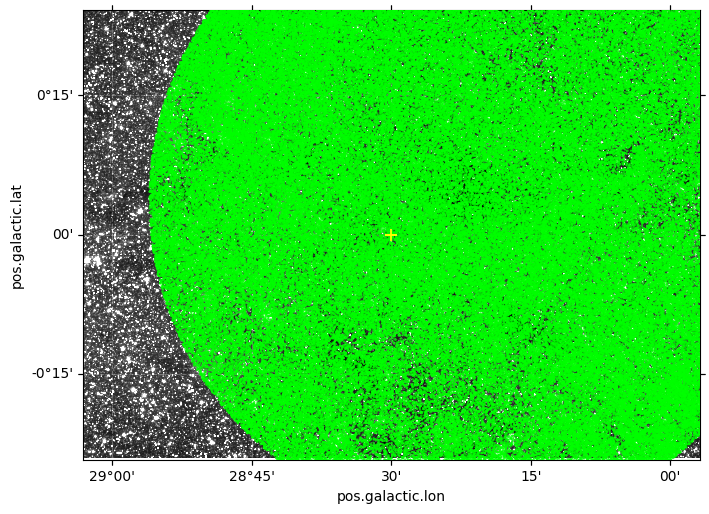

In [30]:
# ========== Load Spitzer image + WCS ==========
fits_file = "GLM_02850_0000_mosaic_I1.fits"
with fits.open(fits_file) as hdul:
    wcs  = WCS(hdul[0].header)
    data = hdul[0].data

print("WCS CTYPE:", wcs.wcs.ctype)   # e.g., ('RA---TAN','DEC--TAN') or ('GLON-TAN','GLAT-TAN')

# ========== Load Gaia catalog (Astropy Table) ==========
gaia_tab = Table.read("Cone_GaiaDR3.fits", hdu=1)

# Robustly convert Astropy Columns -> plain numpy float arrays, handling masks/NaNs
def col_to_float_array(col):
    # If MaskedColumn, drop masked entries
    if hasattr(col, "mask") and col.mask is not None:
        valid_mask = ~col.mask
        arr = np.array(col[valid_mask], dtype=float)
    else:
        arr = np.array(col, dtype=float)
    # Drop NaN/Inf
    arr = arr[np.isfinite(arr)]
    return arr

ra  = col_to_float_array(gaia_tab["ra"])
dec = col_to_float_array(gaia_tab["dec"])

# Make sure ra, dec stay aligned if masking removed different indices:
# Re-build in one pass to preserve alignment.
if hasattr(gaia_tab["ra"], "mask") or hasattr(gaia_tab["dec"], "mask"):
    # Build a single validity mask across both columns
    ra_col, dec_col = gaia_tab["ra"], gaia_tab["dec"]
    m_ra  = getattr(ra_col,  "mask", np.zeros(len(gaia_tab), dtype=bool))
    m_dec = getattr(dec_col, "mask", np.zeros(len(gaia_tab), dtype=bool))
    valid = ~(m_ra | m_dec)
    ra  = np.array(ra_col[valid], dtype=float)
    dec = np.array(dec_col[valid], dtype=float)
    ok  = np.isfinite(ra) & np.isfinite(dec)
    ra, dec = ra[ok], dec[ok]

print(f"Gaia count after cleaning: {len(ra)}")

# Build ICRS SkyCoord from Gaia RA/Dec
c_icrs = SkyCoord(ra * u.deg, dec * u.deg, frame="icrs")

# ========== Decide plotting frame based on WCS ==========
ctype1 = (wcs.wcs.ctype[0] or "").upper()

# Image axes are Galactic — convert Gaia to Galactic
c_gal  = c_icrs.galactic
scatter_transform = "galactic"
x_vals = c_gal.l.to(u.deg).value
y_vals = c_gal.b.to(u.deg).value

# ========== Plot ==========
fig = plt.figure(figsize=(7.2, 7.2))
ax = plt.subplot(projection=wcs)

# Axis labels from WCS
ax.set_xlabel(ax.coords[0].get_axislabel())
ax.set_ylabel(ax.coords[1].get_axislabel())
ax.coords.grid(color="white", ls="--", alpha=0.3)

# Contrast scale for the image
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(data)

ax.imshow(data, origin="lower", cmap="gray", vmin=vmin, vmax=vmax)

# Overlay Gaia points with the correct transform
ax.scatter(
    x_vals, y_vals,
    transform=ax.get_transform(scatter_transform),
    s=1, marker="o", facecolor="none", edgecolor="lime", linewidths=0.6, alpha=0.9, zorder=3
)

# Optional: center crosshair at CRVAL (native WCS coords)
crval = wcs.wcs.crval  # [lon, lat] in the image's native coordinate frame
ax.scatter(
    [crval[0]], [crval[1]],
    transform=ax.get_transform("world"),
    s=70, marker="+", color="yellow", linewidths=1.3, zorder=4
)

ny, nx = data.shape
ax.set_xlim(0, nx)
ax.set_ylim(0, ny)

plt.tight_layout()
plt.show()


In [10]:
print(ra.min(), ra.max())

280.1280130455642 281.29719234625225
